In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.metrics import calculate_metrics, concat_and_process_results

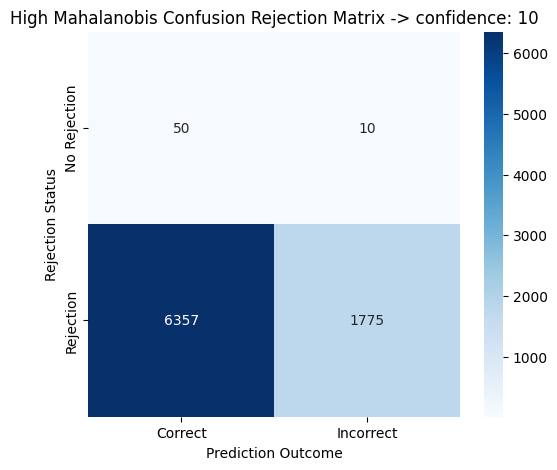

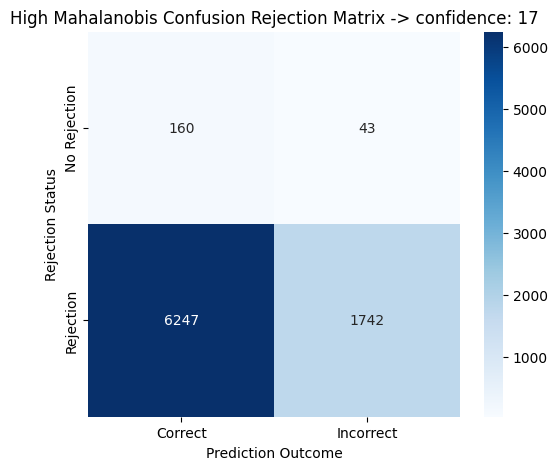

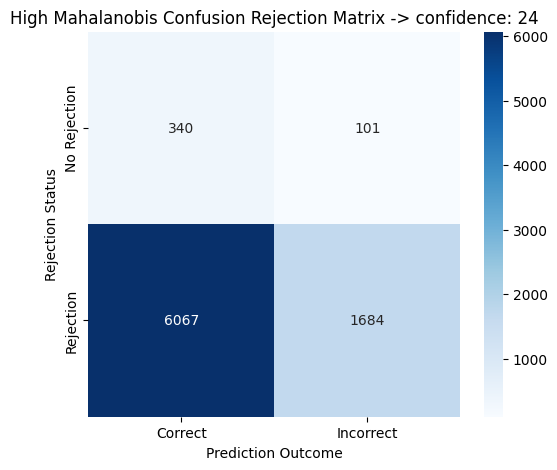

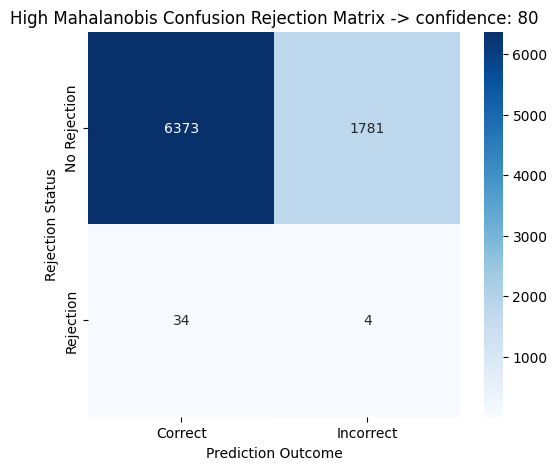

In [88]:
for confidence in [90, 83, 76, 20]:
    data = concat_and_process_results(
        base_folder, original_file, "higher_mahalanobis.csv", confidence / 100
    )
    plot_rejection_matrix(data, confidence)

In [87]:
def plot_rejection_matrix(data, confidence):
    df = data[["rejected", "correct"]]

    # Creating the confusion matrix
    confusion_matrix = pd.DataFrame(
        index=["No Rejection", "Rejection"],
        columns=["Correct", "Incorrect"],
        data=[
            [
                (
                    (df["rejected"] == False) & (df["correct"] == True)
                ).sum(),  # True Accept (TA)
                ((df["rejected"] == False) & (df["correct"] == False)).sum(),
            ],  # False Accept (FA)
            [
                (
                    (df["rejected"] == True) & (df["correct"] == True)
                ).sum(),  # False Reject (FR)
                ((df["rejected"] == True) & (df["correct"] == False)).sum(),
            ],  # True Reject (TR)
        ],
    )

    # Plotting the confusion matrix
    c = 100 - confidence
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    output_file = (
        parent_dir + "/results/rejection_confusion_matrix/high_mahalanobis_confidence"
    )
    fig = plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"High Mahalanobis Confusion Rejection Matrix -> confidence: {c}")
    plt.xlabel("Prediction Outcome")
    plt.ylabel("Rejection Status")
    fig.savefig(f"{output_file}_{c}.png")
    plt.show()
    plt.close()

In [13]:
def plot_accuracy_vs_reject_rate(results, fig_name, experiment_name):
    experiments = results["experiments"]
    reject_rates = [exp["reject_rate"] * 100 for exp in experiments]
    accuracies = [exp["accuracy"] for exp in experiments]

    # Compute the AUC score (area under the curve)
    auc = 0.0
    rates = [exp["reject_rate"] for exp in experiments]
    d = {"higher_mahalanobis": 0.102921317,
         "higher_margin": 0.022241298,
         "higher_knn": 0.027483551,
         "equal_weights": 0.0191128577
    }
    auc = d[experiment_name]
    
    print(f"AUC score for {experiment_name}: {auc}")

    fig = plt.figure(figsize=(8, 6))
    plt.plot(reject_rates, accuracies, marker="o", linestyle="-")
    plt.xlabel("Reject Rate (%)")
    plt.ylabel("Result Accuracy")
    plt.title(f"{experiment_name} - Accuracy vs. Reject Rate")
    plt.grid(True)

    # Add the AUC score annotation to the plot
    plt.text(
        0.05,
        0.95,
        f"AUC: {auc:.6f}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.8),
    )

    # Save the figure before showing it
    fig.savefig(f"{fig_name}.png")
    plt.show()
    plt.close(fig)

In [4]:
from IPython.display import display


def show_experiment_table(result):
    """
    Given a results dictionary with an "experiments" key,
    display a table showing confidence, reject rate, and accuracy.
    """
    # Create a DataFrame from the experiments list
    experiments = result["experiments"]
    df = pd.DataFrame(experiments)

    # If your reject_rate is stored as a fraction, convert it to percentage.
    # Otherwise, comment out the following line.
    df["reject_rate"] = df["reject_rate"] * 100

    # Optionally, sort the DataFrame by confidence
    df = df.sort_values("confidence")

    # Rename columns for clarity in the table
    df = df.rename(
        columns={
            "confidence": "Confidence",
            "reject_rate": "Reject Rate (%)",
            "accuracy": "Accuracy",
        }
    )

    # Display the table
    display(df)

In [4]:
base_folder = "/home/ran/afeka/computer-vision/results/2025-02-04-14-17/"
conclusion_dir = "/home/ran/Github-projects/afeka-computer-vision/results"
original_file = "baseline_no_rejection.csv"
df = pd.read_csv(os.path.join(base_folder, original_file), index_col=0)

In [4]:
# original model no rejection results
# 100 confidence means no rejection at all

original_metrics = calculate_metrics(
    df=df, label_col="true_label", pred_col="prediction"
)

original_model = {
    "accuracy": original_metrics["accuracy"],
    "confidence": 100,
    "reject_rate": 0,
}

In [5]:
# define settings for different experiments
settings = {
    "equal_weights": {"knn": 0.33, "margin": 0.33, "mahalanobis": 0.33},
    "higher_mahalanobis": {"knn": 0.2, "margin": 0.2, "mahalanobis": 0.6},
    "higher_margin": {"knn": 0.2, "margin": 0.6, "mahalanobis": 0.2},
    "higher_knn": {"knn": 0.6, "margin": 0.2, "mahalanobis": 0.2},
}

In [25]:
for setting in settings:
    experiment_file = f"{setting}.csv"
    weights = settings[setting]
    experiments = []
    for confidence in range(20, 90, 7):
        data = concat_and_process_results(
            base_folder, original_file, experiment_file, confidence / 100
        )
        equal_metrics = calculate_metrics(
            df=data[data["rejected"]], label_col="true_label", pred_col="prediction"
        )
        reject_rate = len(data[data["rejected"]]) / len(data)
        experiments.append(
            {
                "confidence": confidence,
                "accuracy": equal_metrics["accuracy"],
                "reject_rate": reject_rate,
            }
        )

    # Extract and reverse the accuracy values
    reversed_accuracies = [d["accuracy"] for d in experiments]
    reveresed_rate = [d["reject_rate"] for d in experiments][::-1]
    for i, d in enumerate(experiments):
        experiments[i]["accuracy"] = reversed_accuracies[i]
        experiments[i]["reject_rate"] = reveresed_rate[i]

    results = {
        "models": weights,
        "original_model": original_model,
        "experiments": experiments,
    }

    output_filename = os.path.join(conclusion_dir, f"{setting}.json")
    with open(output_filename, "w") as f:
        json.dump(results, f, indent=4)

    print(f"results saved to {output_filename}")

results saved to /home/ran/Github-projects/afeka-computer-vision/results/equal_weights.json
results saved to /home/ran/Github-projects/afeka-computer-vision/results/higher_mahalanobis.json
results saved to /home/ran/Github-projects/afeka-computer-vision/results/higher_margin.json
results saved to /home/ran/Github-projects/afeka-computer-vision/results/higher_knn.json


higher_mahalanobis
AUC score for higher_mahalanobis: 0.102921317


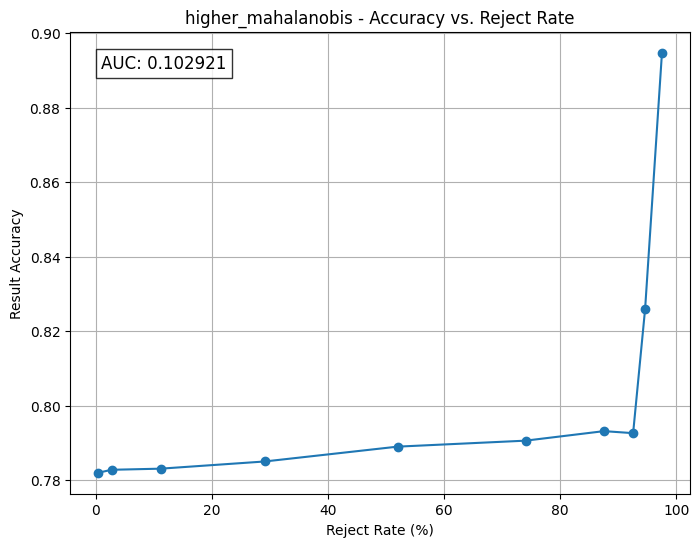

equal_weights
AUC score for equal_weights: 0.0191128577


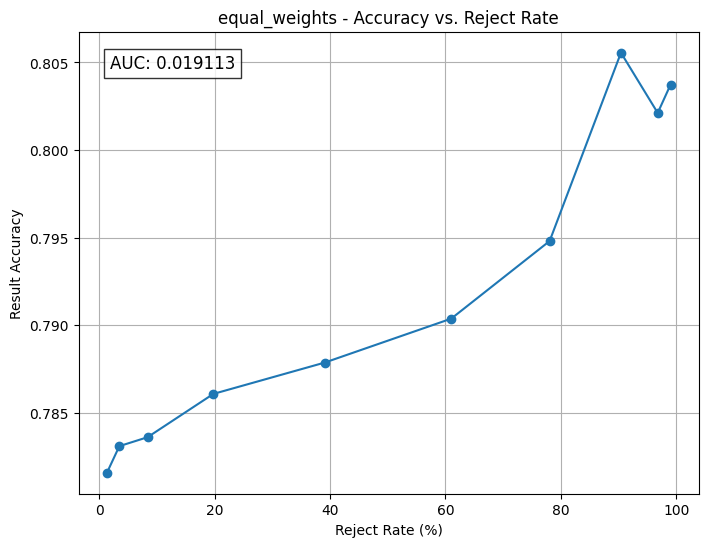

higher_margin
AUC score for higher_margin: 0.022241298


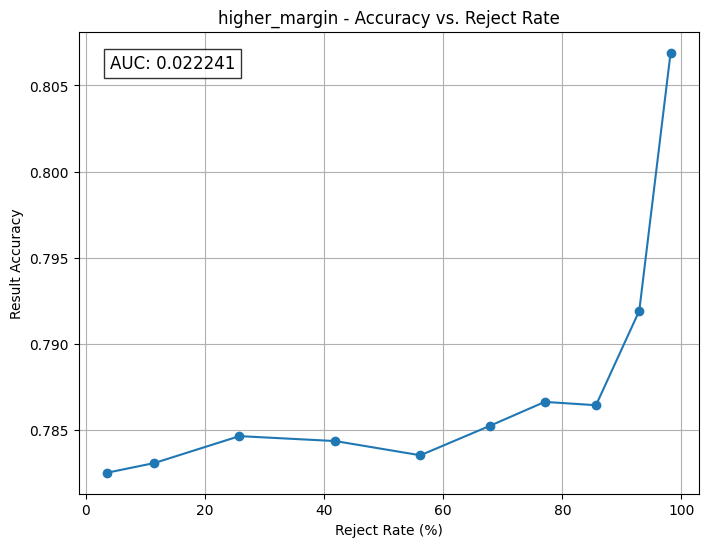

higher_knn
AUC score for higher_knn: 0.027483551


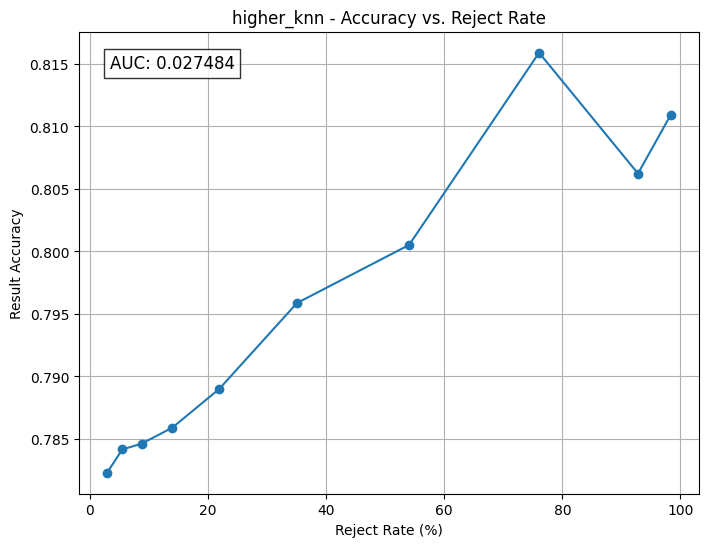

In [14]:
for filename in os.listdir(conclusion_dir):
    if filename.endswith(".json"):
        experiment_name = filename.split(".json")[0]
        print(experiment_name)
        fig_name = os.path.join(conclusion_dir, f"{experiment_name}")
        with open(os.path.join(conclusion_dir, filename), "r") as f:
            result = json.load(f)
        plot_accuracy_vs_reject_rate(result, fig_name, experiment_name)

In [39]:
# roc auc
for filename in os.listdir(conclusion_dir):
    if filename.endswith(".json"):
        experiment_name = filename.split(".json")[0]
        print(experiment_name)
        with open(os.path.join(conclusion_dir, filename), "r") as f:
            result = json.load(f)

        rates = [d["reject_rate"] for d in result["experiments"]]
        acc = [d["accuracy"] for d in result["experiments"]]
        auc_score = abs(np.trapz(rates, acc))
        print(f"AUC score for {experiment_name}: {auc_score}")

higher_mahalanobis
AUC score for higher_mahalanobis: 0.10194612933845024
equal_weights
AUC score for equal_weights: 0.012696401032510565
higher_margin
AUC score for higher_margin: 0.020925885671578878
higher_knn
AUC score for higher_knn: 0.01116459567457025


In [27]:
for filename in os.listdir(conclusion_dir):
    if filename.endswith(".json"):
        experiment_name = filename.split(".json")[0]
        print(experiment_name)
        with open(os.path.join(conclusion_dir, filename), "r") as f:
            result = json.load(f)
        show_experiment_table(result)

higher_mahalanobis


,Confidence,Accuracy,Reject Rate (%)
0,20,0.894737,97.521973
1,27,0.825893,94.616699
2,34,0.792576,92.553711
3,41,0.793118,87.536621
4,48,0.790561,74.035645
5,55,0.788953,51.989746
6,62,0.784967,29.089355
7,69,0.783039,11.181641
8,76,0.782738,2.734375
9,83,0.781950,0.463867


equal_weights


,Confidence,Accuracy,Reject Rate (%)
0,20,0.803738,99.035645
1,27,0.802120,96.801758
2,34,0.805556,90.429688
3,41,0.794808,78.063965
4,48,0.790378,60.998535
5,55,0.787873,39.074707
6,62,0.786083,19.750977
7,69,0.783612,8.349609
8,76,0.783102,3.454590
9,83,0.781585,1.306152


higher_margin


,Confidence,Accuracy,Reject Rate (%)
0,20,0.806897,98.181152
1,27,0.791932,92.919922
2,34,0.786458,85.656738
3,41,0.786651,77.050781
4,48,0.785264,67.846680
5,55,0.783555,56.164551
6,62,0.784379,41.882324
7,69,0.784666,25.781250
8,76,0.783106,11.499023
9,83,0.782544,3.540039


higher_knn


,Confidence,Accuracy,Reject Rate (%)
0,20,0.810924,98.352051
1,27,0.806236,92.810059
2,34,0.815900,76.062012
3,41,0.800525,54.052734
4,48,0.795873,35.058594
5,55,0.788997,21.887207
6,62,0.785908,13.952637
7,69,0.784625,8.752441
8,76,0.784164,5.480957
9,83,0.782301,2.905273
